# Réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

# 0. Chargement des modules et données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D
from tensorflow.keras.optimizers import SGD,Adam,Nadam,Adadelta
from tensorflow import keras

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df.shape

(48836, 24)

In [3]:
df.sort_values('Error %', ascending=False).head()

,Unnamed: 0,Reference Security,Bid Price,Ask Price,Mid Price,Cpn,Maturity,Common Eqty / Tot Assets,Debt / Common Equity,TCE Ratio,...,Amt Out,Total Assets,BCLASS Level 3,Guarantee Type,Guarantor Type,Collat Type,PD_1y,reprice,maturity_years,Error %
5909,5909,ZS424035 Corp,0.010,0.750,0.3800,1.5000,04/26/2024,-147.17300,NaN,-149.82800,...,1.186770e+09,3359.72,Other Industrial,Multiple,Subsidiaries,SR SECURED,1.0,40.007513,2.709589,10428.292944
1456,1456,AN346569 Corp,0.125,0.700,0.4125,3.8750,10/25/2022,12.72580,177.366,-23.21850,...,4.000000e+08,1808.09,Electric,Multiple,Parent & Subsidiaries,SR SECURED,1.0,40.007513,1.205479,9598.791076
827,827,AL458635 Corp,0.250,1.750,1.0000,6.2500,06/15/2022,NaN,NaN,NaN,...,7.500000e+08,NaN,Consumer Cyclical,N.A.,N.A.,SR UNSECURED,1.0,42.507983,0.843836,4150.798276
44900,44900,QJ879163 Corp,0.407,1.481,0.9440,9.8776,12/01/2025,5.74708,467.713,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.0,40.007513,4.309589,4138.084024
44899,44899,QJ879163 Corp,0.396,1.499,0.9475,9.8776,12/01/2025,5.74708,467.713,4.97044,...,2.000000e+08,1002610.00,Banking,N.A.,N.A.,SUBORDINATED,1.0,40.007513,4.309589,4122.428832


In [80]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]

df.columns

Index(['Unnamed: 0', 'Reference Security', 'Bid Price', 'Ask Price',
       'Mid Price', 'Cpn', 'Maturity', 'Common Eqty / Tot Assets',
       'Debt / Common Equity', 'TCE Ratio', 'Tot Debt / Tot Capital',
       'Tot Cap (Local Crncy)', 'Is Covered', 'Is Convertible', 'Amt Out',
       'Total Assets', 'BCLASS Level 3', 'Guarantee Type', 'Guarantor Type',
       'Collat Type', 'PD_1y', 'reprice', 'maturity_years', 'Error %'],
      dtype='object')

In [5]:
def count_nan(df):
    for col_name in df.columns:
        n_nan = df[col_name].isna().sum()
        if n_nan > 0:
            print("Colomn : ", col_name)  
            print("NaN : {}/{}".format(n_nan,len(df[col_name])))
            print("===============================================")

In [6]:
count_nan(df)

Colomn :  Common Eqty / Tot Assets
NaN : 1766/44445
Colomn :  Debt / Common Equity
NaN : 2579/44445
Colomn :  TCE Ratio
NaN : 2471/44445
Colomn :  Tot Debt / Tot Capital
NaN : 2016/44445
Colomn :  Tot Cap (Local Crncy)
NaN : 2014/44445
Colomn :  Total Assets
NaN : 2361/44445
Colomn :  Guarantee Type
NaN : 20/44445
Colomn :  Guarantor Type
NaN : 20/44445


In [7]:
#RENSEIGNER LES RATIOS FINANCIERS / VARIABLES CONSIDEREES 

#df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','Tot Debt / Tot Capital','BCLASS Level 3',"TCE Ratio","PD_1y"]]
df1 = df[['Common Eqty / Tot Assets','TCE Ratio','Tot Debt / Tot Capital','Tot Cap (Local Crncy)','Is Covered','Is Convertible','Amt Out','BCLASS Level 3', 'Guarantee Type','Total Assets', 'Guarantor Type', 'Collat Type','Debt / Common Equity','PD_1y']]
df1 = df1[df1['Debt / Common Equity']<2500]
df1 = df1[df1['TCE Ratio']>-100]
#df1.replace(np.nan, 0.0,inplace=True)
df1.dropna(inplace=True)
count_nan(df1)

In [8]:
#df1 = df1.dropna(how = 'any') 
df1.head()

,Common Eqty / Tot Assets,TCE Ratio,Tot Debt / Tot Capital,Tot Cap (Local Crncy),Is Covered,Is Convertible,Amt Out,BCLASS Level 3,Guarantee Type,Total Assets,Guarantor Type,Collat Type,Debt / Common Equity,PD_1y
2,5.65522,5.41231,84.0491,1077950.0,False,False,1.000000e+09,Banking,N.A.,3040430.0,N.A.,SR UNSECURED,526.924,0.012445
3,35.98800,2.22137,53.9594,125576.0,False,False,6.060820e+08,Communications,N.A.,155063.0,N.A.,SR UNSECURED,121.425,0.020474
4,5.71381,5.24664,85.8881,333470.0,False,False,1.500000e+09,Banking,N.A.,809688.0,N.A.,SR UNSECURED,619.080,0.001146
5,23.50830,19.21360,63.4410,151388.0,False,False,6.000000e+08,Consumer Cyclical,Single,235381.0,Parent,COMPANY GUARNT,173.568,0.001179
6,4.54799,3.85114,85.6341,226753.0,False,False,1.100000e+09,Banking,N.A.,627244.0,N.A.,SR UNSECURED,680.681,0.002144


In [9]:
df1.shape

(36781, 14)

In [10]:
df1 = df1.drop_duplicates(subset=df1.columns.difference(['PD_1y']))
df1.shape

(3657, 14)

# 1. Préparation des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [11]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [12]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level 3','Guarantee Type','Guarantor Type','Collat Type','Is Covered','Is Convertible']
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

## a. Statistiques descriptives

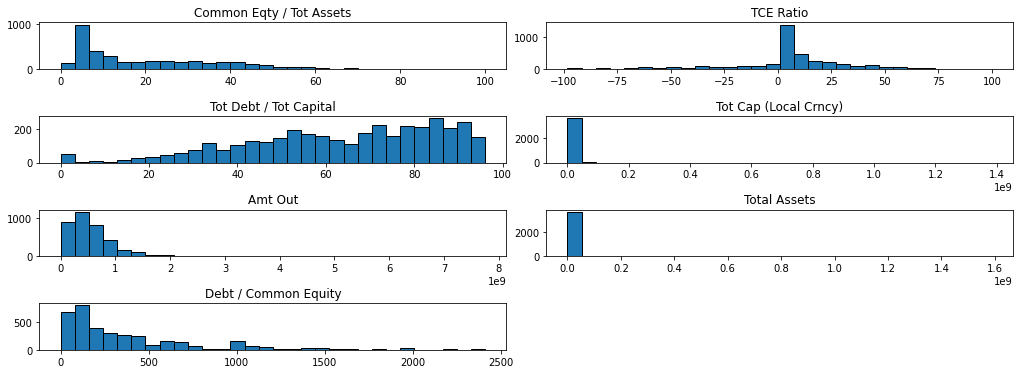

In [13]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):

    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(8, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
    #plt.xlim(0,0.001)
# espacement entre les subplots
fig.tight_layout(pad=0.1)
#fig.savefig('continuous_distrib.png')

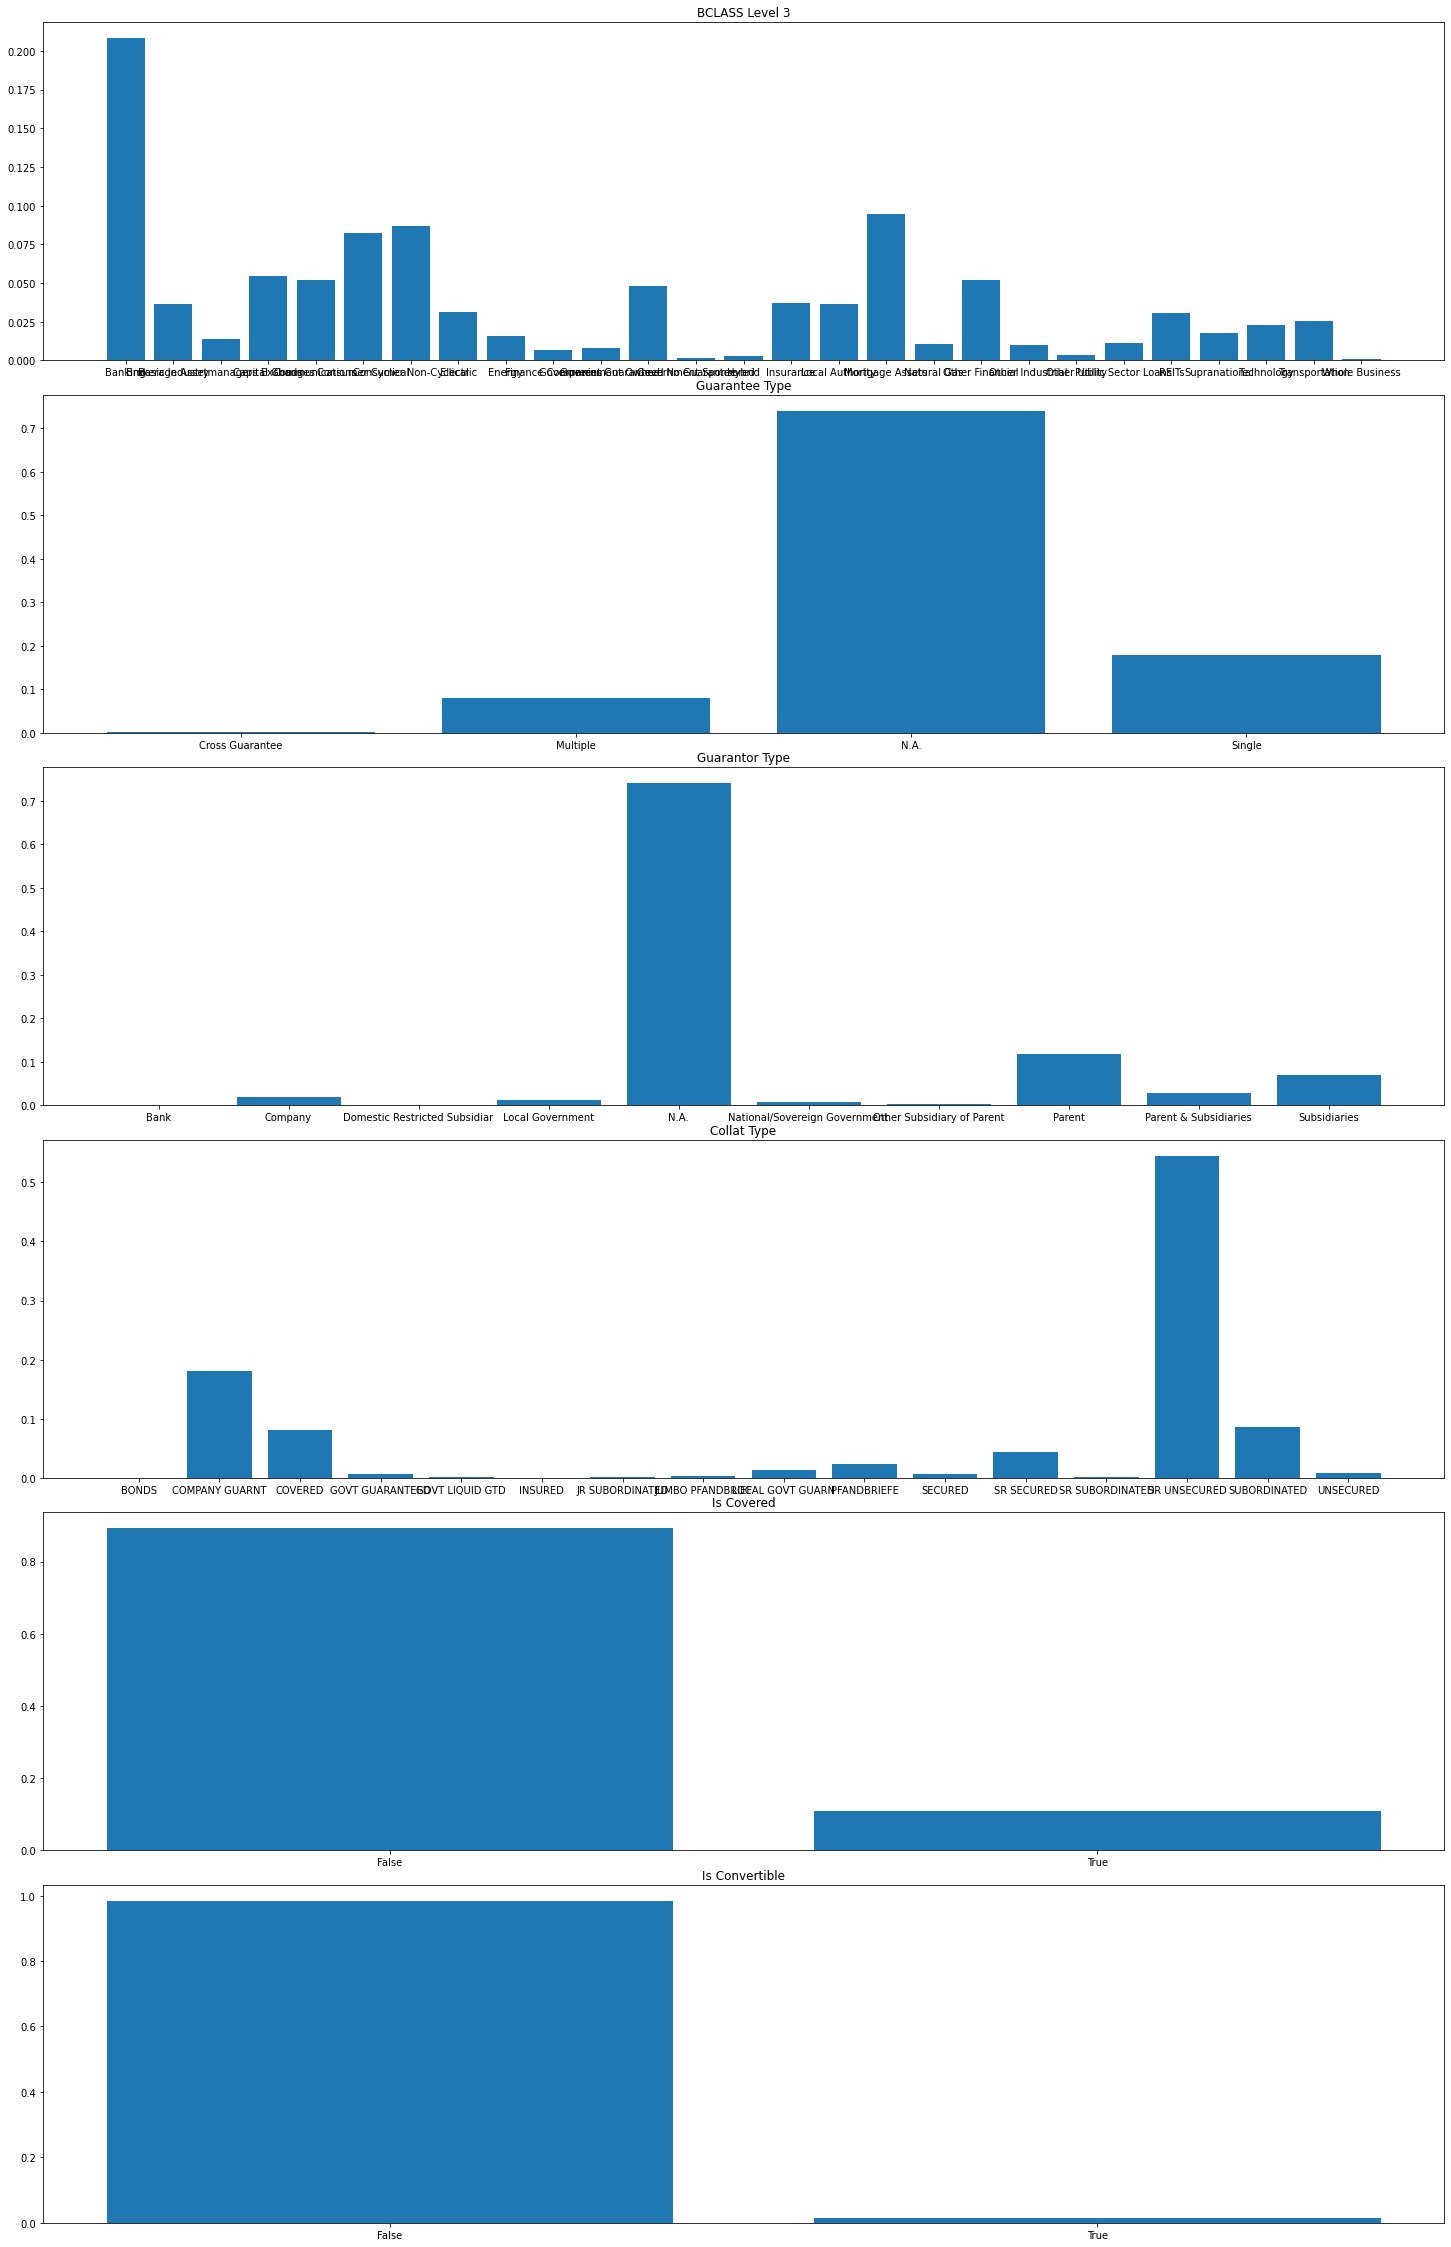

In [14]:
# Bar plots for discrete features
fig = plt.figure(figsize=(20, 36))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(7, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
    
fig.tight_layout(pad=0.15)
fig.savefig('discrete_distrib.png')

## b. Traitement des données

In [15]:
## A FAIRE COMME CELA :
"""
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_submit)

X_train_submit = enc.transform(X_train_submit)
X_test_submit = enc.transform(X_test_submit)

"""



class Pipeline:
    def __init__(self, X_train, X_full = None):
        """
        Se fit sur le jeu de TRAIN, une seule fois
        """
        self.ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False).fit(X_full[:,discrete_features_idx])
        self.std_scaler = preprocessing.StandardScaler().fit(X_train[:,continuous_features_idx])
        print(self.ohe.categories_)
        
    def traitement(self,X):
        """
        Permet de traiter n'importe quel vecteur X ensuite
        """
    
        X_continuous_scaled = self.std_scaler.transform(X[:,continuous_features_idx])
        X_discrete_encoded = self.ohe.transform(X[:,discrete_features_idx])
        print('moyenne = {}'.format(np.mean(X_continuous_scaled)))
        
        X_processed = np.hstack((X_discrete_encoded, X_continuous_scaled))
    
        return X_processed


In [16]:
X_train, X_test_, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.1,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

pipe = Pipeline(X_train,X_full)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test_)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation',
       'Whole Business'], dtype=object), array(['Cross Guarantee', 'Multiple', 'N.A.', 'Single'], dtype=object), array(['Bank', 'Company', 'Domestic Restricted Subsidiar',
       'Local Government', 'N.A.', 'National/Sovereign Government',
       'Other Subsidiary of Parent', 'Parent', 'Parent & Subsidiaries',
       'Subsidiaries'], dtype=object), array(['BONDS', 'COMPANY GUARNT', 'COVERED', 'GOVT GUARANTEED',
       'GOVT LIQUID GTD', 'INSURED', 'JR S

# II. Réseaux de neurones : prédiction de la PD

## a. Implémentation du modèle

In [17]:
X_train.shape
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

(3291, 68)

In [200]:
model = Sequential()
model.add(Dense(units=1200,input_dim=68,))#activation="sigmoid")) #6 is good
model.add(Dense(units=1200))
model.add(Dense(units=1200))
#model.add(Dropout(0.2))
model.add(Dense(units=1,activation="sigmoid"))

learning_rate = 0.000005

sgd = SGD(learning_rate)  #lr = 0.02
adam = Adam(learning_rate) #lr = 0.001

#nadam = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#dim première couche = nombre de variables du df 

**Fonction sigmoïde :** continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [201]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
#model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])
#model.compile(loss=tf.keras.losses.Huber(delta=.05),optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
model.compile(loss='mean_absolute_percentage_error',optimizer=adam,metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [202]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 1200)              82800     
_________________________________________________________________
dense_47 (Dense)             (None, 1200)              1441200   
_________________________________________________________________
dense_48 (Dense)             (None, 1200)              1441200   
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 1201      
Total params: 2,966,401
Trainable params: 2,966,401
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
120/120 [==============================] - 1s 9ms/step - loss: 20917.8125 - mean_absolute_percentage_error: 20917.8125 - val_loss: 9021.9346 - val_mean_absolute_percentage_error: 9021.9346
Epoch 2/30
120/120 [==============================] - 1s 8ms/step - loss: 8930.4424 - mean_absolute_percentage_error: 8930.4424 - val_loss: 4835.9980 - val_mean_absolute_percentage_error: 4835.9980
Epoch 3/30
120/120 [==============================] - 1s 8ms/step - loss: 5118.5518 - mean_absolute_percentage_error: 5118.5518 - val_loss: 2774.8074 - val_mean_absolute_percentage_error: 2774.8074
Epoch 4/30
120/120 [==============================] - 1s 8ms/step - loss: 3304.4805 - mean_absolute_percentage_error: 3304.4802 - val_loss: 1710.1035 - val_mean_absolute_percentage_error: 1710.1035
Epoch 5/30
120/120 [==============================] - 1s 8ms/step - loss: 2428.1565 - mean_absolute_percentage_error: 2428.1565 - val_loss: 1064.8804 - val_mean_absolute_percentage_error: 1064.8804
Epoch 6/

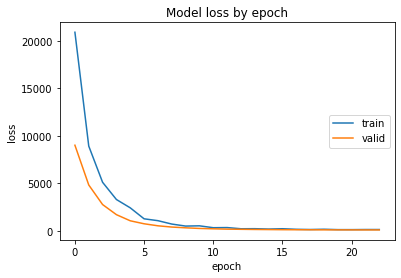

In [203]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#callback = None
history = model.fit(np.squeeze(X_train), y_train,         # Train the model using the training set...
          batch_size=30, epochs=30,
          verbose=1, validation_split=0.2,steps_per_epoch=120,)#callbacks=[callback])           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
#plt.savefig('nn.png')
plt.show()

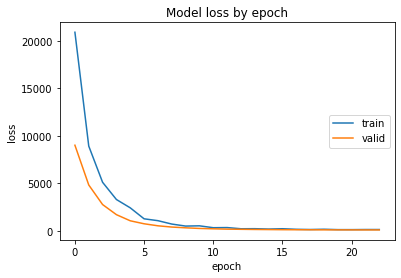

In [207]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.savefig('nn.png')
plt.show()

In [208]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MAPE):', resultat[1])

12/12 [==============================] - 0s 3ms/step - loss: 88.9961 - mean_absolute_percentage_error: 88.9961
Valeur de l'erreur sur les données de test (loss): 88.99606323242188
Précision sur les données de test (MAPE): 88.99606323242188


In [209]:
.019638868048787117

0.019638868048787117

In [210]:
#LASSO

from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)

#clf = linear_model.ElasticNet(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

-0.00032618513897952894

In [211]:
#KNN

from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)


0.1957923331975585

In [212]:
#GAUSS

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
"""
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0)
gpr.fit(X_train, y_train)
gpr.score(X_test, y_test)
"""


'\nkernel = DotProduct() + WhiteKernel()\ngpr = GaussianProcessRegressor(kernel=kernel,random_state=0)\ngpr.fit(X_train, y_train)\ngpr.score(X_test, y_test)\n'

In [213]:
#SVR
from sklearn.svm import SVR
regr = SVR(C=.4, epsilon=0.0001, verbose=True)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

[LibSVM]

0.23367302323347527

In [214]:
#SVR

"""
def ppp(eps):
    regr = SVR(C=.4, epsilon=0.01)
    regr.fit(X_train, y_train)
    score = regr.score(X_test, y_test)
    return score
    

x_ = np.linspace(1e-3,9e-1,1000)

scores = np.vectorize(ppp)(x_)

print("best epsilon = {}".format(x_[list(scores).index(np.max(scores))]))


"""


'\ndef ppp(eps):\n    regr = SVR(C=.4, epsilon=0.01)\n    regr.fit(X_train, y_train)\n    score = regr.score(X_test, y_test)\n    return score\n    \n\nx_ = np.linspace(1e-3,9e-1,1000)\n\nscores = np.vectorize(ppp)(x_)\n\nprint("best epsilon = {}".format(x_[list(scores).index(np.max(scores))]))\n\n\n'

## b. Observation des résultats 

In [215]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return np.abs(théo - préd) / théo

In [232]:
def ViewResults(model, X_test, y_test):
    prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
    théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
    prediction, théorique = prediction.reset_index() , théorique.reset_index()

    results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
    results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)
    
    results.sort_values('Ecart_relatif',inplace=True)
    
    #print(results.tail(20))
    k=.2
    
    
    print("\n\nL'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")
    premiere_bissectrice = np.linspace(0,k * 1e-1,100)
    
    plt.plot(premiere_bissectrice,premiere_bissectrice, color='red')
    plt.scatter(results["Théorique"],results["Prédiction"])
    
    
    plt.xlim(-k*1e-2,k * 1e-1)
    plt.ylim(-k*1e-2,k * 1e-1)
    plt.savefig('nn_pred.png')
    plt.show()

Resultat pour la regression SVR


L'écart relatif moyen est de 83.1596659011553%


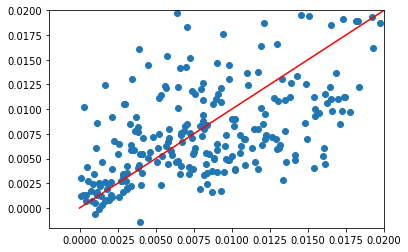

In [229]:
print('Resultat pour la regression SVR')
ViewResults(regr, X_test, y_test)

Resultat pour la regression 5-NN


L'écart relatif moyen est de 109.83325460691708%


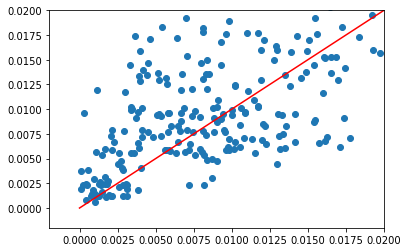

In [230]:
print('Resultat pour la regression 5-NN')
ViewResults(neigh,X_test,y_test)

Resultat pour la regression via Dense Neural Net


L'écart relatif moyen est de 88.99606296409878%


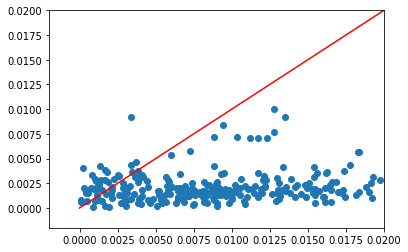

In [233]:
print('Resultat pour la regression via Dense Neural Net')
ViewResults(model,X_test,y_test)

---------------

# III. Réseaux de neurones : Test classification multi-classe

## a. Classification des PD

**Transformation de la distribution** 

In [107]:
lam = 1/y_train.mean()

In [108]:
def loi_expo(x,lam) : 
    return lam * np.exp(- lam * x)

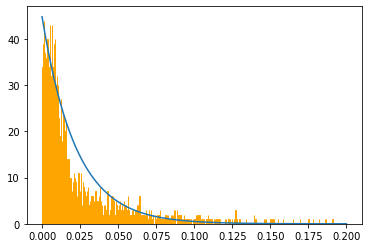

In [110]:
from pylab import *
x_arg = linspace(0, 0.2, 100)
y_arg = loi_expo(x_arg,lam)# * 8

plot(x_arg, y_arg)
plt.hist(y_train, range = (0, 0.2), bins = 1000, edgecolor='orange')
show()

In [48]:
def distrib_function(x,lam) : 
    return 1 - np.exp(- lam * x)

y_train_exp = distrib_function(y_train,lam)
y_test_exp = distrib_function(y_test,lam)

(array([34., 39., 31., 43., 47., 46., 52., 43., 38., 44., 30., 39., 32.,
        45., 53., 43., 45., 40., 44., 34., 55., 46., 43., 39., 48., 61.,
        44., 44., 39., 52., 54., 44., 54., 42., 48., 52., 45., 37., 43.,
        37., 33., 35., 47., 27., 38., 34., 38., 37., 32., 25., 37., 29.,
        28., 26., 24., 20., 23., 19., 15., 16., 23., 23., 24., 19., 14.,
        23., 23., 22., 18., 13., 22., 17., 18., 18., 20., 16., 16., 16.,
        16., 18., 20., 27., 18., 14., 21., 21., 18., 29., 22., 32., 24.,
        31., 26., 31., 34., 31., 28., 33., 38., 82.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

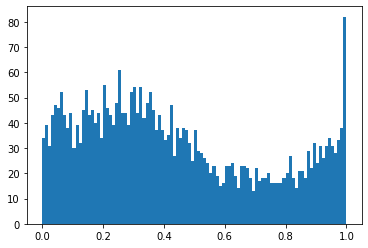

In [49]:
plt.hist(y_train_exp, range = (0, 1), bins = 100)

**Règle du coude :** déterminer le nombre de clusters 

In [50]:
from sklearn.cluster import KMeans

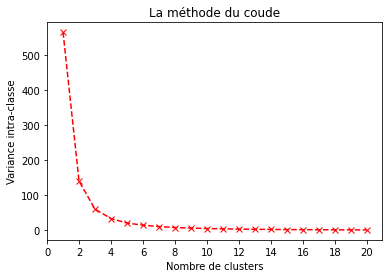

In [51]:
def regle_du_coude(base_input, nb_cluster_teste):
    
    distortions = []
    df = pd.DataFrame(columns = ['X', 'Y']) 
    df["X"]=base_input
    df["Y"]=base_input

    for k in range(1,nb_cluster_teste+1):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    
    plt.plot(range(1,nb_cluster_teste+1), distortions, 'rx--')
    plt.xticks(range(0,nb_cluster_teste+1,2))
    plt.xlabel('Nombre de clusters',)
    plt.ylabel('Variance intra-classe')
    plt.title('La méthode du coude')
    plt.show()
    
regle_du_coude(y_train_exp,20)

**Clustering :**

In [52]:
#Au départ : reprendre base de train et de test créées dans la partie I. 
#X_train, y_train, X_test, y_test

class Discretizer:
    def __init__(self, y_train, nb_class=6):
        
        self.nb_class = nb_class
        self.y_train = y_train.reshape((-1,1))

        self.kbins = KBinsDiscretizer(n_bins=self.nb_class, encode='ordinal', strategy='kmeans')#strategy : uniform, quantile, kmeans
        self.kbins.fit(self.y_train)
        
        
    def discretize(self,y):
        y = y.reshape((-1,1))
        y_class = self.kbins.transform(y)
        return y_class

In [53]:
nb_class = 6
discretizer = Discretizer(y_train_exp, nb_class=nb_class)

y_train_class = discretizer.discretize(y_train_exp)
y_test_class  = discretizer.discretize(y_test_exp)

In [54]:
y_train

array([0.0312266 , 0.06754044, 0.0285428 , ..., 0.00804611, 0.03108146,
       0.00382763])

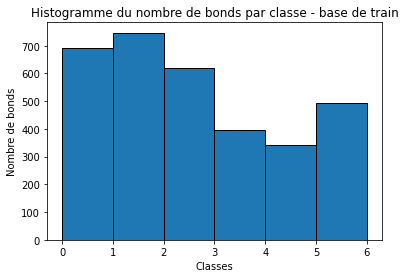

In [55]:
plt.hist(y_train_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

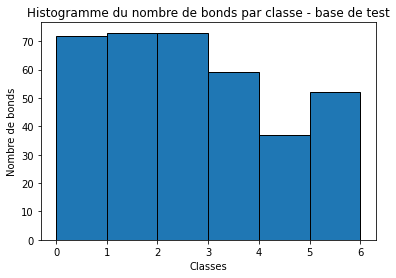

In [56]:
plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

## b. Implémentation du modèle

In [65]:

model = Sequential()
#model.add(Conv1D(12, 2, activation='relu',input_shape=input_shape[1:]))
model.add(Dense(units=2000,input_dim=68)) #6 is good
model.add(Dense(units=2000))
model.add(Dropout(0.4))
model.add(Dense(units=nb_class,activation="softmax")) #output


#32, 3, activation='relu', input_shape=input_shape[2:])(x)




In [66]:
from tensorflow import keras 

model.compile(optimizer=keras.optimizers.Adam(lr=0.0003),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [67]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [68]:




history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=20, epochs=100,
          verbose=1, validation_split=0.1,steps_per_epoch=250)  

Epoch 1/100
250/250 [==============================] - 3s 10ms/step - loss: 1.5870 - sparse_categorical_accuracy: 0.3744 - val_loss: 1.4424 - val_sparse_categorical_accuracy: 0.4182
Epoch 2/100
250/250 [==============================] - 2s 10ms/step - loss: 1.5065 - sparse_categorical_accuracy: 0.3972 - val_loss: 1.4001 - val_sparse_categorical_accuracy: 0.4152
Epoch 3/100
250/250 [==============================] - 2s 9ms/step - loss: 1.4757 - sparse_categorical_accuracy: 0.4150 - val_loss: 1.4068 - val_sparse_categorical_accuracy: 0.4394
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 1.4671 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.3986 - val_sparse_categorical_accuracy: 0.4273
Epoch 5/100
250/250 [==============================] - 3s 10ms/step - loss: 1.4475 - sparse_categorical_accuracy: 0.4121 - val_loss: 1.3778 - val_sparse_categorical_accuracy: 0.4152
Epoch 6/100
250/250 [==============================] - 2s 9ms/step - loss: 1.4354 - sparse_

Epoch 46/100
250/250 [==============================] - 2s 10ms/step - loss: 1.4082 - sparse_categorical_accuracy: 0.4351 - val_loss: 1.3740 - val_sparse_categorical_accuracy: 0.4424
Epoch 47/100
250/250 [==============================] - 3s 10ms/step - loss: 1.4165 - sparse_categorical_accuracy: 0.4268 - val_loss: 1.3700 - val_sparse_categorical_accuracy: 0.4424
Epoch 48/100
250/250 [==============================] - 3s 10ms/step - loss: 1.4046 - sparse_categorical_accuracy: 0.4309 - val_loss: 1.3888 - val_sparse_categorical_accuracy: 0.3970
Epoch 49/100
250/250 [==============================] - 2s 10ms/step - loss: 1.4099 - sparse_categorical_accuracy: 0.4307 - val_loss: 1.3555 - val_sparse_categorical_accuracy: 0.4455
Epoch 50/100
250/250 [==============================] - 3s 11ms/step - loss: 1.4015 - sparse_categorical_accuracy: 0.4322 - val_loss: 1.3870 - val_sparse_categorical_accuracy: 0.4303
Epoch 51/100
250/250 [==============================] - 2s 9ms/step - loss: 1.4076 - 

12/12 [==============================] - 0s 3ms/step - loss: 1.4104 - sparse_categorical_accuracy: 0.4016
The final loss on the TEST set is: 1.41.
The final sparse_categorical_accuracy on the TEST set is: 0.40.


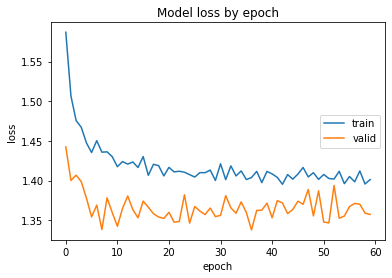

In [69]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [70]:
#OvsRest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#poly & degree=11

OvR_clf = OneVsRestClassifier(SVC(kernel='poly',degree=3),n_jobs=-1).fit(X_train, y_train_class)


print(OvR_clf.score(X_test,y_test_class))

0.43169398907103823


In [72]:
# Random forest:

from sklearn.multiclass import OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier


    
rf_clf = OutputCodeClassifier(
    estimator=RandomForestClassifier(n_estimators=800,
                                     criterion='gini', #{“gini”, “entropy”}
                                     max_depth=100, #default=None
                                     min_samples_split=2, #int or float, default=2
                                     random_state=42,
                                     max_features='auto',
                                     bootstrap=True,
                                     min_samples_leaf=1
                                    ),
    random_state=42,n_jobs=-1)

rf2_clf = RandomForestClassifier(n_estimators=800,
                                     criterion='gini', #{“gini”, “entropy”}
                                     max_depth=100, #default=None
                                     min_samples_split=2, #int or float, default=2
                                     random_state=42,
                                     max_features='auto',
                                     bootstrap=True,
                                     min_samples_leaf=1
                                    )

rf2_clf.fit(X_train, np.ravel(y_train_class))



print(rf2_clf.score(X_test,y_test_class))
"""
{'estimator__n_estimators': 800, 
 'estimator__min_samples_split': 2, 
 'estimator__min_samples_leaf': 1, 
 'estimator__max_features': 'auto', 
 'estimator__max_depth': 100, 
 'estimator__bootstrap': True}
"""



0.4726775956284153


"\n{'estimator__n_estimators': 800, \n 'estimator__min_samples_split': 2, \n 'estimator__min_samples_leaf': 1, \n 'estimator__max_features': 'auto', \n 'estimator__max_depth': 100, \n 'estimator__bootstrap': True}\n"

In [73]:
#RF FINE TUNING
"""
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}
"""



"\nfrom sklearn.model_selection import RandomizedSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'estimator__n_estimators': n_estimators,\n               'estimator__max_features': max_features,\n               'estimator__max_depth': max_depth,\n               'estimator__min_samples_split': min_samples_split,\n               'estimator__min_samples_leaf': min_samples_leaf,\n               'estimator__bootstrap': boot

In [74]:

#rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#rf_random.fit(X_train, y_train_class)

In [75]:
def ViewClassResult(model,continuous=False):
    if continuous:
        y=model.predict(np.squeeze(X_test))
        y_predicted = [np.argmax(pred) for pred in y]
    else:
        y_predicted=model.predict(np.squeeze(X_test))
    
    print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))
    CM = confusion_matrix(y_test_class[:,0], y_predicted)
    ConfusionMatrixDisplay(CM).plot()
    
def ShowFeatureImportances(model):
    """
    Shows the feature importances for a given model
    """
    importance = model.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

173 / 366


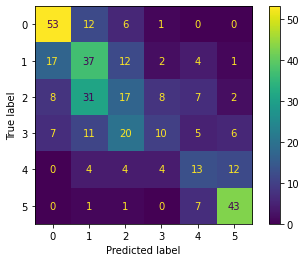

In [76]:
ViewClassResult(rf2_clf)


158 / 366


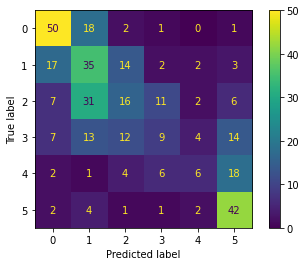

In [79]:
ViewClassResult(OvR_clf)

In [77]:
#ShowFeatureImportances(rf2_clf)

147 / 366


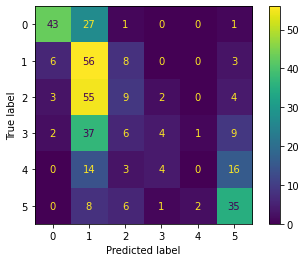

In [78]:
ViewClassResult(model,continuous=True)

In [61]:
#print(pipe.ohe.categories_)

In [62]:
flat_list = [item for sublist in pipe.ohe.categories_ for item in sublist]

In [1]:
features = flat_list + continuous_features

NameError: name 'flat_list' is not defined

In [64]:
continuous_features

['Common Eqty / Tot Assets',
 'TCE Ratio',
 'Tot Debt / Tot Capital',
 'Tot Cap (Local Crncy)',
 'Amt Out',
 'Total Assets',
 'Debt / Common Equity']